## Fundamentals of TensorFlow and learning algorithms
- [Tutorial Video](https://www.youtube.com/watch?v=tPYj3fFJGjk&t=1958s)
- [TensorFlow Introduction Module](https://colab.research.google.com/drive/1F_EWVKa8rbMXi3_fG0w7AtcscFq7Hi7B#forceEdit=true&sandboxMode=true&scrollTo=UU4MMhB_rxvz)
- [Learning Algorithms Module](https://colab.research.google.com/drive/15Cyy2H7nT40sGR7TBN5wBvgTd57mVKay#forceEdit=true&sandboxMode=true&scrollTo=qcII_xj9Ntyo)

### Install and import packages 

In [12]:
# pip install tensorflow
# pip install scikit-learn

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf  
from tensorflow.keras import layers, models
print(tf.version) # Should be >= 2

<module 'tensorflow._api.v2.version' from 'c:\\Users\\chris\\OneDrive\\COMP 560\\Midterm Project\\comp-560-project\\Virtual_Environment\\Lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


### Creating variables in TensorFlow
- Tensor = vector
- Rank/degree = dimensions involved in a tensor
    - Rank0 = scalar
- Feature = input info
- Label = output info

Supervised learning:
    - Trained using already known features and labels (compares ai prediction to actual label)
    - Produces labels given a different set of features

In [13]:
rank1_tensor = tf.Variable(["Test", "something", "ok"], tf.string) # One dimensional vector
rank2_tensor = tf.Variable([["test", "ok"], ["test", "yes"], ["test", "yes"]], tf.string) # Two dimensional vector
rank3_tensor = tf.Variable([[[1], [2]], [[1], [2]], [[1], [2]]], tf.int32) # Two dimensional vector
print(tf.rank(rank2_tensor)) # Returns dimension of vector 
print(rank2_tensor.shape) # Returns shape of vector (#items in first dimension, #items in second dimension)
print(rank3_tensor.shape) # Returns shape of vector (#items in dimension1, #items in dimension2, #items in dimension3)

tf.Tensor(2, shape=(), dtype=int32)
(3, 2)
(3, 2, 1)


### Practice data about the Titanic

In [14]:
# Load Titanic deaths dataset - try to find linear pattern correlating to likelihood of death
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
print(y_train, '\n', y_eval)

clear_output()
dftrain.head() # Returns the first 5 entries of the dataframe

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


### Creating graphs to understand the data

<Axes: >

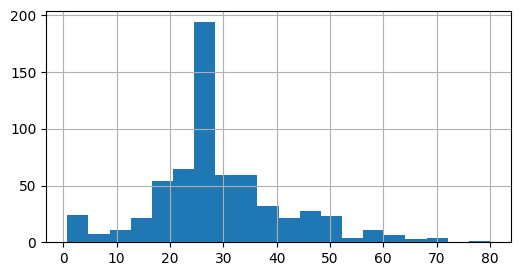

In [15]:
plt.figure(figsize=(6, 3))
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

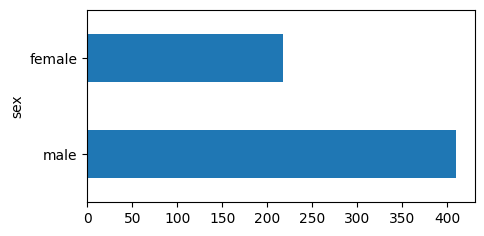

In [16]:
plt.figure(figsize=(5, 2.5))
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

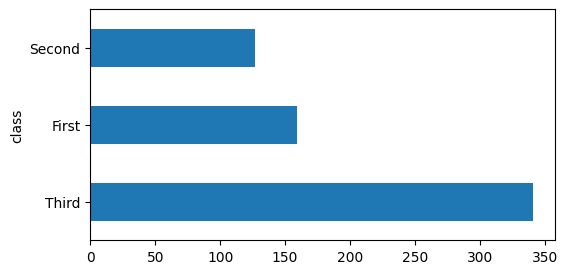

In [17]:
plt.figure(figsize=(6, 3))
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

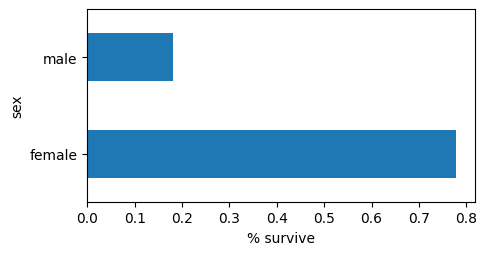

In [18]:
plt.figure(figsize=(5, 2.5))
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

### Creating a list of data categories to be fed into the model

In [19]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary) # creates categorical column
  indicator_column = tf.feature_column.indicator_column(categorical_column) # reformat into the parameter type of the model object constructor
  feature_columns.append(indicator_column) # adds column objects to the list:

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns, '\n\n Towns: ', dftrain['embark_town'].unique())

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(np.int64(1), np.int64(0), np.int64(3), np.int64(4), np.int64(2), np.int64(5), np.int64(8)), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(np.int64(0), np.int64(1), np.int64(2), np.int64(5), np.int64(3), np.int64(4)), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string,

In [27]:
# Put the feature columns into a format it can handle
# Define input layers
inputs = {
    'sex': tf.keras.Input(shape=(1,), dtype=tf.string),
    'n_siblings_spouses': tf.keras.Input(shape=(1,), dtype=tf.int64),
    'parch': tf.keras.Input(shape=(1,), dtype=tf.int64),
    'class': tf.keras.Input(shape=(1,), dtype=tf.string),
    'deck': tf.keras.Input(shape=(1,), dtype=tf.string),
    'embark_town': tf.keras.Input(shape=(1,), dtype=tf.string),
    'alone': tf.keras.Input(shape=(1,), dtype=tf.string),
    'age': tf.keras.Input(shape=(1,), dtype=tf.float32),
    'fare': tf.keras.Input(shape=(1,), dtype=tf.float32),
}
# Define categorical processing
sex_lookup = tf.keras.layers.StringLookup(vocabulary=['male', 'female'], output_mode='one_hot')
class_lookup = tf.keras.layers.StringLookup(vocabulary=['Third', 'First', 'Second'], output_mode='one_hot')
deck_lookup = tf.keras.layers.StringLookup(vocabulary=['unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'], output_mode='one_hot')
embark_lookup = tf.keras.layers.StringLookup(vocabulary=['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], output_mode='one_hot')
alone_lookup = tf.keras.layers.StringLookup(vocabulary=['n', 'y'], output_mode='one_hot')

# Apply lookup layers to categorical inputs
encoded_features = [
    sex_lookup(inputs['sex']),
    class_lookup(inputs['class']),
    deck_lookup(inputs['deck']),
    embark_lookup(inputs['embark_town']),
    alone_lookup(inputs['alone']),
]

# Define normalizer layers for numerical features
age_normalizer = tf.keras.layers.Normalization()
fare_normalizer = tf.keras.layers.Normalization()

# Normalize numerical features
encoded_features.append(age_normalizer(inputs['age']))
encoded_features.append(fare_normalizer(inputs['fare']))

x = tf.keras.layers.concatenate(encoded_features)
# Define dense layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

c:\Users\chris\OneDrive\COMP 560\Midterm Project\comp-560-project\Virtual_Environment\Lib\site-packages\keras\src\models\functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'sex' mapping to value <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'sex' (via `Input(..., name='sex')`)
  warnings.warn(
c:\Users\chris\OneDrive\COMP 560\Midterm Project\comp-560-project\Virtual_Environment\Lib\site-packages\keras\src\models\functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'n_siblings_spouses' mapping to value <KerasTensor shape=(None, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_1> which has name 'keras_tensor_1'. Change the tensor name to 'n_siblings_spouses' (via `Input(..., na

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 3)         │          0 │ input_layer[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_1     │ (None, 4)         │          0 │ input_layer_3[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_2     │ (None, 9)         │          0 │ input_layer_4[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_3     │ (None, 5)         │          0 │ input_layer_5[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_4     │ (None, 3)         │          0 │ input_layer_6[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 1)         │          3 │ input_layer_7[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 1)         │          3 │ input_layer_8[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26)        │          0 │ string_lookup[0]… │
│ (Concatenate)       │                   │            │ string_lookup_1[… │
│                     │                   │            │ string_lookup_2[… │
│                     │                   │            │ string_lookup_3[… │
│                     │                   │            │ string_lookup_4[… │
│                     │                   │            │ normalization[0]… │
│                     │                   │            │ normalization_1[

 Total params: 20,103 (78.54 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 6 (32.00 B)

In [28]:
model = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

### Create model, load data into model, evaluate model's accuracy
- Data is fed in batches (of size 32 in this case) to prevent massive datasets from bogging down RAM
- The number of epochs = the number of times the model sees the entire dataset
- The make_dataset function below defines how the data will be broken into epochs and batches
    - The model needs a `tf.data.Dataset` object as input
- **The video originally used a linear regression model, but I believe this uses a logistic regression**
    - I am not sure what the logic is behind using ReLU (Rectified Linear Unit) activation functions for the first two layers is but supposedly this is commonplace
    - In my understanding, this model takes on piece of data that goes to 128 nuerons in the first layer, which then create a map to the 128 nuerons in the second layer, which are interpreted by the sigmoid function into one probability value between 0 and 1

In [ ]:
def make_dataset(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32): # returns tf.data.Dataset object
  ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
  if shuffle:
    ds = ds.shuffle(1000)  # randomize order of data
  ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
  return ds  # return the dataset

# feature data is dftrain (does not contain survival) and label data is y_train (survival)
train_dataset = make_dataset(dftrain, y_train)
eval_dataset = make_dataset(dfeval, y_eval, num_epochs=1, shuffle=False)

# The following several lines don't work because TensorFlow recently replaced estimator with keras
# Create the model based on the data categories - It is an estimator that uses linear classification
# linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# linear_est.train(train_input_fn)  # trains the model - not completely sure how this works behind the scenes
# result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data
# print(result['accuracy'])
# print(result)

model = models.Sequential() # The keras sequential model allows for layers to be added sequentially
model.add(layers.DenseFeatures(feature_columns))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # This final layer converts the previous layers' output into probabilities

# The optimizer adjusts the model's learning process (trying to understand this gets pretty in depth)
# Binary cross-entropy is the conventional function to use for measuring the discrepancy between predicted probabilities and actual labels
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training statistics:\n")
model.fit(train_dataset, epochs=10) # Train the model
loss, accuracy = model.evaluate(eval_dataset) # Evaluate the model

clear_output()
print('\nAccuracy tested against evaluation dataset:', round(accuracy*100, 2), "%")

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

### Predict chance of survival for a single person

In [ ]:

# Old code below
predictions = list(model.predict(eval_dataset))
person = np.random.randint(0, len(dfeval))
clear_output()
print(dfeval.loc[person])
print(f"\nPredicted chance of survival: {round(predictions[person][0]*100, 2)}%")
survival = "yes" if y_eval[person] else "no"
print(f"Did they survive: {survival}")

ValueError: Exception encountered when calling Sequential.call().

[1mLayer "dense_9" expects 1 input(s), but it received 9 input tensors. Inputs received: [<tf.Tensor 'Cast:0' shape=(32,) dtype=float32>, <tf.Tensor 'data_8:0' shape=(32,) dtype=string>, <tf.Tensor 'data_5:0' shape=(32,) dtype=string>, <tf.Tensor 'data_6:0' shape=(32,) dtype=string>, <tf.Tensor 'data_7:0' shape=(32,) dtype=string>, <tf.Tensor 'Cast_1:0' shape=(32,) dtype=float32>, <tf.Tensor 'data_2:0' shape=(32,) dtype=int64>, <tf.Tensor 'data_3:0' shape=(32,) dtype=int64>, <tf.Tensor 'data:0' shape=(32,) dtype=string>][0m

Arguments received by Sequential.call():
  • inputs={'sex': 'tf.Tensor(shape=(32,), dtype=string)', 'age': 'tf.Tensor(shape=(32,), dtype=float32)', 'n_siblings_spouses': 'tf.Tensor(shape=(32,), dtype=int64)', 'parch': 'tf.Tensor(shape=(32,), dtype=int64)', 'fare': 'tf.Tensor(shape=(32,), dtype=float32)', 'class': 'tf.Tensor(shape=(32,), dtype=string)', 'deck': 'tf.Tensor(shape=(32,), dtype=string)', 'embark_town': 'tf.Tensor(shape=(32,), dtype=string)', 'alone': 'tf.Tensor(shape=(32,), dtype=string)'}
  • training=False
  • mask={'sex': 'None', 'age': 'None', 'n_siblings_spouses': 'None', 'parch': 'None', 'fare': 'None', 'class': 'None', 'deck': 'None', 'embark_town': 'None', 'alone': 'None'}

### Other learning models
- Linear/logistic regression is likely the best choice for 
- Classification
    - Given data that belongs in groups (like ___ for example) produces a classification based on what group the model thinks a data element should be in 